In [1]:
import os
current_dir = %pwd
project_dir = os.path.dirname(current_dir)
%cd $project_dir

d:\DATA\a.asri\doc-classifier


# Évaluation et Interprétation des Modèles de Classification

Ce notebook permet d'évaluer et d'interpréter les performances de différents modèles de deep learning pour la classification de documents. Les modèles incluent ResNet50, MobileNetV2, CNN et SqueezeNet.


In [22]:
# Importer les bibliothèques nécessaires
import os
import time
import math
from math import pi
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn import metrics
from src import read_jsonfile, create_test_dataset, inference
from sklearn.metrics import accuracy_score
from IPython.display import Markdown, display
from tensorflow.keras.preprocessing import image
import random
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


# Paramètres de configuration
batch_size = 32
image_size = (224, 224)  # Taille des images pour les modèles
num_classes = 6

### Chargement des modèles et des données
Les données d'entraînement et de test sont chargées depuis des fichiers CSV. Les chemins des images et les étiquettes sont extraits.

In [23]:
# Définir le chemin des modèles et des historiques
model_names = ['MobileNetV2', 'ResNet50', 'EfficientNetB1', 'CNN', 'SqueezeNet']
model_paths = [f"models/{name}_ckpt_best_acc.keras" for name in model_names]
history_paths = [f"models/{name}_history.json" for name in model_names]
models = [load_model(path) for path in model_paths]

# Lire le fichier CSV de test
df_test = pd.read_csv('data/processed/DL_test.csv')
X_test = df_test['image_path'].values
Y_test = df_test['category'].values
test_dataset = create_test_dataset(X_test, Y_test)

In [24]:
# Initialiser les listes pour les résultats
histories = []
losses = []
accuracies = []
classification_reports = []
confusion_matrices = []
results = []

# Dictionnaire de catégories
cat_dict = {
    "Email": 0,
    "Handwritten": 1,
    "Invoice": 2,
    "ID Card": 3,
    "Passeport": 4,
    "Scientific publication": 5
}
categories = list(cat_dict.keys())

# Initialiser les listes pour les précisions par catégorie
category_accuracies = {category: [] for category in categories}

### Définition des fonction (à déplacer dans src ultérieurement)

In [25]:
import seaborn as sns 

# Fonction pour tracer la matrice de confusion
def plot_confusion_matrix(conf_matrix, model_name, cat_dict, ax):
    # Obtenir les catégories
    categories = list(cat_dict.keys())
    
    # Tracer la matrice de confusion
    sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False, 
                xticklabels=categories, yticklabels=categories, ax=ax)
    ax.set_title(f'{model_name}')
    ax.set_xlabel('Classe prédite')
    ax.set_ylabel('Classe réelle')


# Fonction pour mesurer le temps de prédiction
def measure_inference_time(model, dataset, device='CPU'):
    if device == 'GPU':
        with tf.device('/GPU:0'):
            start_time = time.time()
            model.predict(dataset)
            end_time = time.time()
    else:
        start_time = time.time()
        model.predict(dataset)
        end_time = time.time()
    
    return (end_time - start_time) / len(dataset)

# Fonction pour calculer la précision moyenne
def calculate_mean_accuracy(model, dataset, true_labels):
    pred_probs = model.predict(dataset)
    pred_labels = np.argmax(pred_probs, axis=1)
    accuracy = accuracy_score(true_labels, pred_labels)
    return accuracy

In [6]:
from sklearn.metrics import accuracy_score

# Charger les modèles et leurs historiques
for model_name, model_path, history_path in zip(model_names, model_paths, history_paths):
    # Charger le modèle
    model = load_model(model_path)
    
    # Charger l'historique
    history = read_jsonfile(history_path)
    histories.append(history)
    
    # Évaluer le modèle
    loss, accuracy = model.evaluate(test_dataset)
    losses.append(loss)
    accuracies.append(accuracy)
    
    # Prédictions
    pred = model.predict(test_dataset)
    classification_report = metrics.classification_report(Y_test, pred.argmax(axis=1), output_dict=True)
    classification_reports.append(classification_report)

    # Calculer la matrice de confusion
    conf_matrix = metrics.confusion_matrix(Y_test, pred.argmax(axis=1))
    confusion_matrices.append((conf_matrix, model_name))
    
    # Stocker les précisions par catégorie
    for category, idx in cat_dict.items():
        # Ajouter une précision de 0.0 si la catégorie n'est pas présente dans le rapport
        if str(idx) in classification_report:
            category_accuracies[category].append(classification_report[str(idx)]['precision'])
        else:
            category_accuracies[category].append(0.0)

    # Temps de prédiction sur CPU
    cpu_time = measure_inference_time(model, test_dataset, device='CPU')
    
    # Temps de prédiction sur GPU
    gpu_time = measure_inference_time(model, test_dataset, device='GPU')
    
    # Précision moyenne
    mean_accuracy = calculate_mean_accuracy(model, test_dataset, Y_test)
    
    image_size_str = f"{image_size[0]}x{image_size[1]}"  # Taille en pixels
    
    # Ajouter les résultats au tableau
    results.append([model_name, cpu_time, gpu_time, mean_accuracy * 100, image_size_str])

# Créer le DataFrame
columns = ["Modèle", "Mean inference time - CPU (s)", "Mean inference time - GPU (s)", "Mean Accuracy (%)", "Image size"]
df_inference_time = pd.DataFrame(results, columns=columns)

    

# Convertir les données en dataframe
df_accuracies = pd.DataFrame(category_accuracies, index=model_names)

54/54 [==============================] - 11s 206ms/step


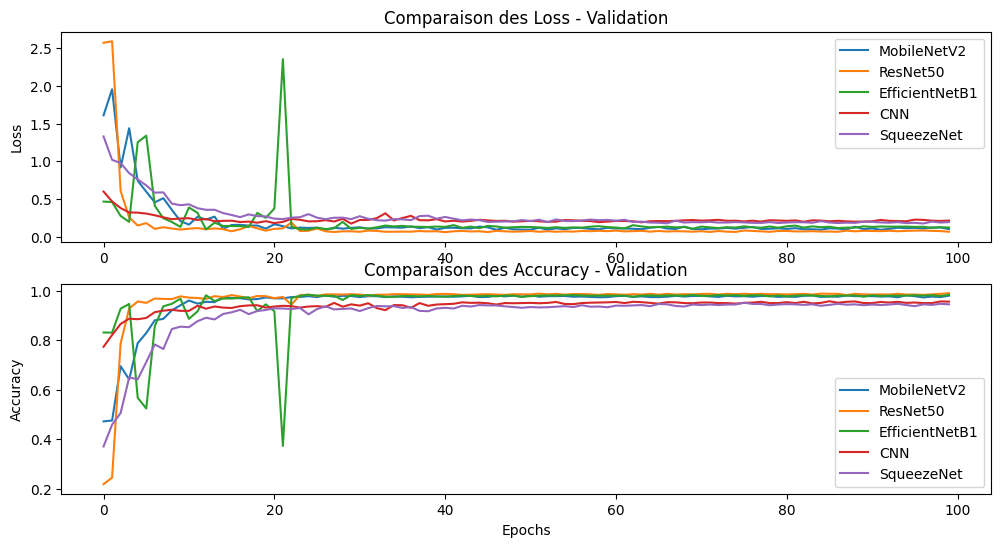

In [7]:
# Visualiser les résultats
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

# 1) Comparaison de Loss et Accuracy global
axes[0].set_title('Comparaison des Loss - Validation')
for i, history in enumerate(histories):
    #axes[0].plot(history['loss'], label=f'{model_names[i]} - train')
    axes[0].plot(history['val_loss'], label=f'{model_names[i]}')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].set_title('Comparaison des Accuracy - Validation')
for i, history in enumerate(histories):
    #axes[1].plot(history['accuracy'], label=f'{model_names[i]} - train')
    axes[1].plot(history['val_accuracy'], label=f'{model_names[i]}')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

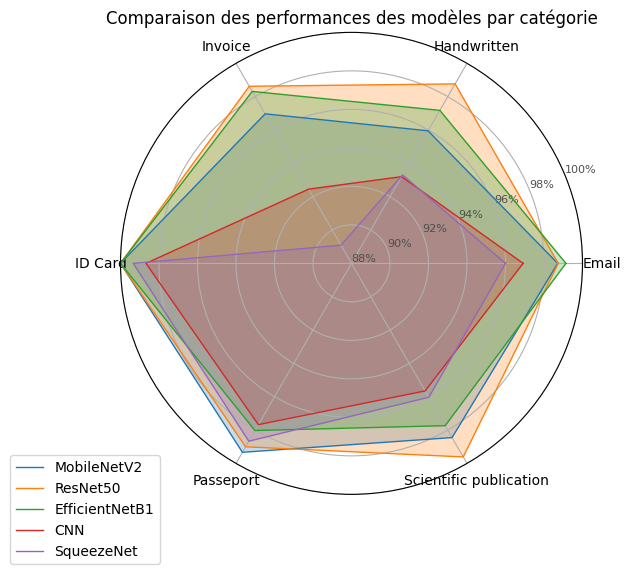

In [8]:
# Créer un radar plot
fig, ax = plt.subplots(figsize=(7, 6), subplot_kw=dict(polar=True))

# Angle pour chaque catégorie
angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

# Dessiner une catégorie à la fois
for model_name in model_names:
    values = df_accuracies.loc[model_name].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=model_name)
    ax.fill(angles, values, alpha=0.25)

# Ajouter les labels des catégories
plt.xticks(angles[:-1], categories)

# Ajuster l'échelle
yticks = [0.88, 0.90, 0.92, 0.94, 0.96, 0.98, 1.0]
ytick_labels = [f'{int(y * 100)}%' for y in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, color="#4F4F4F", size=8)
ax.set_ylim(0.88, 1.0)

# Ajouter une légende
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.title('Comparaison des performances des modèles par catégorie')

plt.show()

In [9]:
# Enregistrer le tableau récapitulatif dans un fichier CSV
df_accuracies.to_csv('results\category_accuracies_summary.csv', index=True)

#Afficher les précisions des modèles par catégories
df_accuracies_percentage_ = df_accuracies*100
df_accuracies_percentage = df_accuracies_percentage_.round(1)

# Convertir le DataFrame en Markdown
markdown_table = df_accuracies_percentage.to_markdown()

# Afficher le Markdown dans la cellule de code
display(Markdown("### Précisions des modèles retenus par catégories"))
display(Markdown(markdown_table))

### Précisions des modèles retenus par catégories

|                |   Email |   Handwritten |   Invoice |   ID Card |   Passeport |   Scientific publication |
|:---------------|--------:|--------------:|----------:|----------:|------------:|-------------------------:|
| MobileNetV2    |    98.7 |          96   |      97   |     100   |        99.3 |                     98.4 |
| ResNet50       |    98.7 |          98.8 |      98.6 |     100   |        99   |                     99.6 |
| EfficientNetB1 |    99.1 |          97.2 |      98.3 |     100   |        98   |                     97.7 |
| CNN            |    96.9 |          93.2 |      92.5 |      98.7 |        97.7 |                     95.7 |
| SqueezeNet     |    96   |          93.3 |      89.1 |      99.3 |        98.7 |                     96   |

### Matrices de confusion

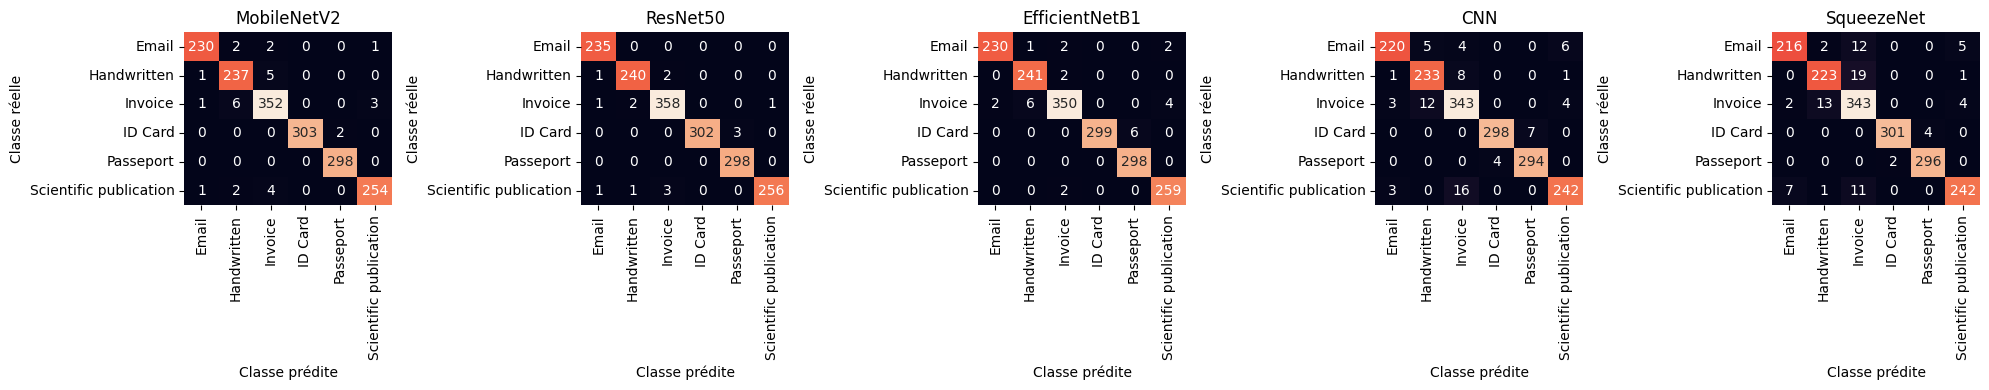

In [10]:
# Nombre de modèles
num_models = len(confusion_matrices)

# Créer la figure et les axes
fig, axes = plt.subplots(1, num_models, figsize=(20, 4))

# Tracer chaque matrice de confusion
for i, (conf_matrix, model_name) in enumerate(confusion_matrices):
    plot_confusion_matrix(conf_matrix, model_name, cat_dict, axes[i])

plt.tight_layout()
plt.show()

### Analyse des temps de prédiction 

In [11]:
# Arrondir les valeurs des précisions
df_inference_time["Mean Accuracy (%)"] = df_inference_time["Mean Accuracy (%)"].round(1)

# Définir 'Modèle' comme index
df_inference_time.set_index('Modèle', inplace=True)

md_table_time = df_inference_time.to_markdown()

display(Markdown("### Résultats de temps de prédiction des modèles"))
display(Markdown(md_table_time))


### Résultats de temps de prédiction des modèles

| Modèle         |   Mean inference time - CPU (s) |   Mean inference time - GPU (s) |   Mean Accuracy (%) | Image size   |
|:---------------|--------------------------------:|--------------------------------:|--------------------:|:-------------|
| MobileNetV2    |                        0.228755 |                        0.226275 |                98.2 | 224x224      |
| ResNet50       |                        0.238775 |                        0.240897 |                99.1 | 224x224      |
| EfficientNetB1 |                        0.245947 |                        0.243854 |                98.4 | 224x224      |
| CNN            |                        0.18227  |                        0.184054 |                95.7 | 224x224      |
| SqueezeNet     |                        0.21303  |                        0.207108 |                95.1 | 224x224      |

### Exemples de prédictions avec probabilité

### Results for Model: MobileNetV2

1/1 [==============================] - 0s 23ms/step


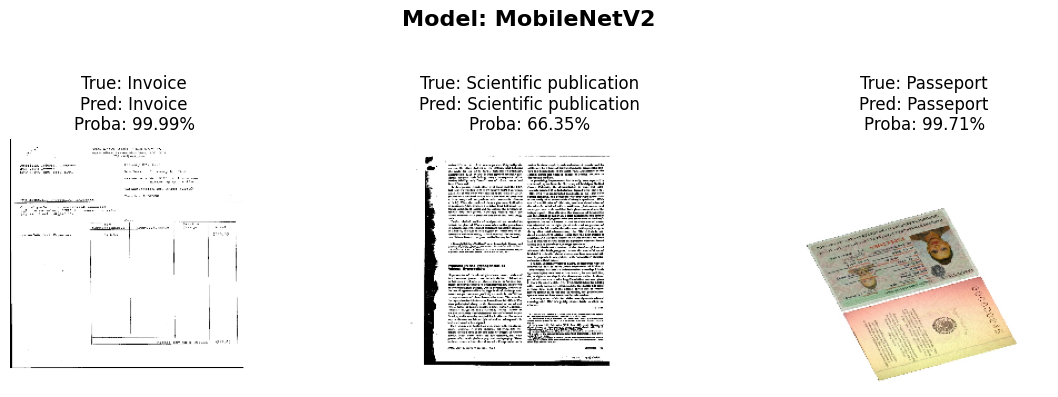

### Results for Model: ResNet50

1/1 [==============================] - 0s 11ms/step


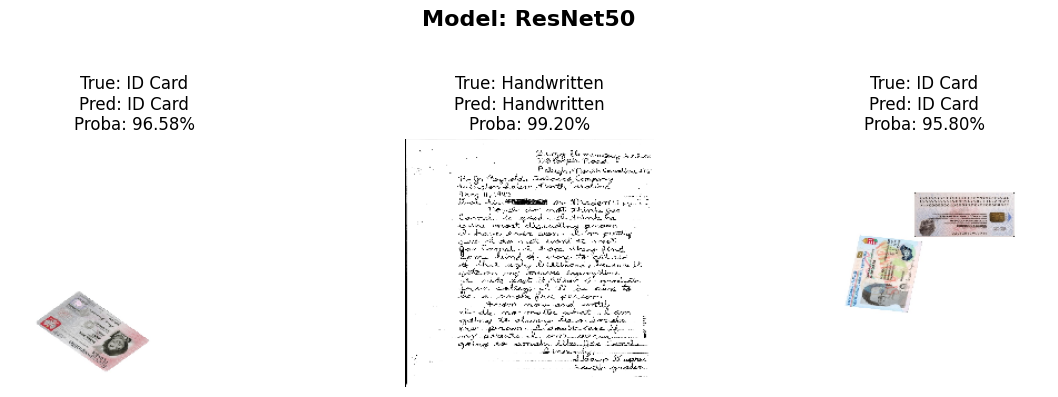

### Results for Model: EfficientNetB1

1/1 [==============================] - 0s 33ms/step


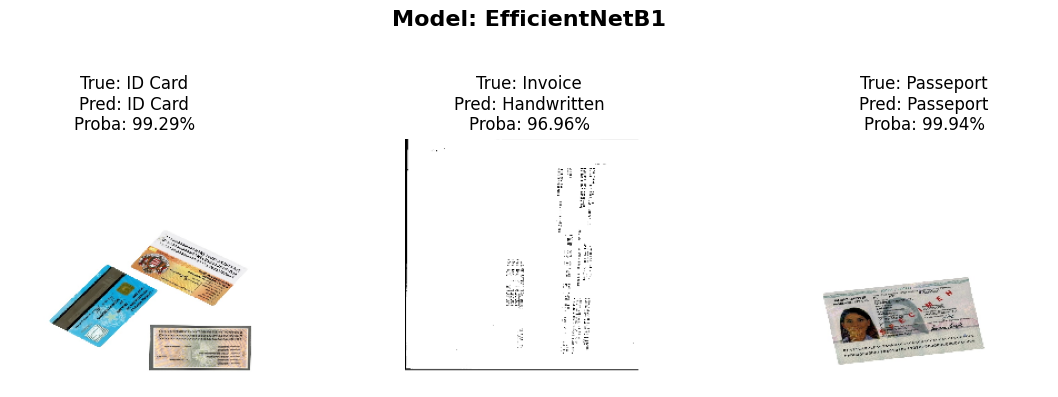

### Results for Model: CNN

1/1 [==============================] - 0s 17ms/step


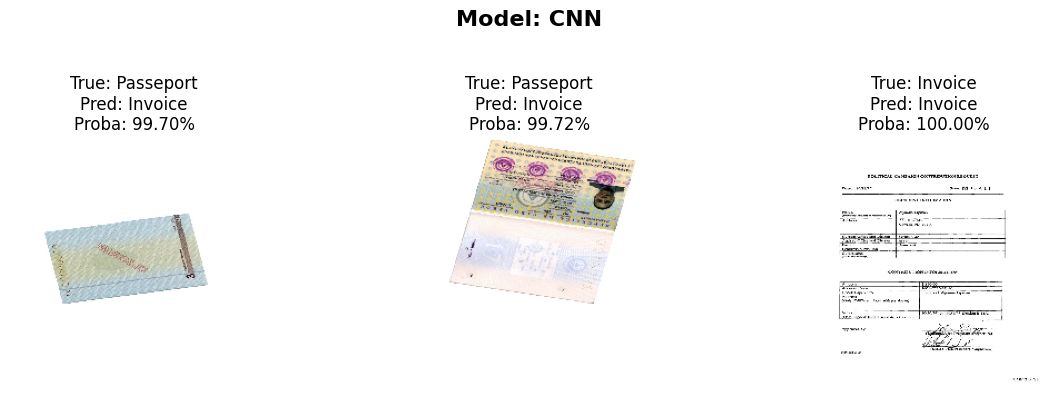

### Results for Model: SqueezeNet

1/1 [==============================] - 0s 12ms/step


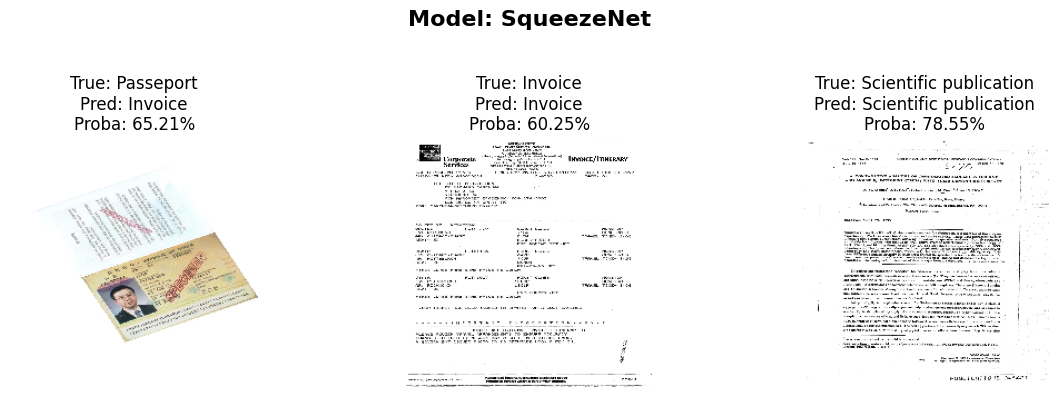

In [26]:
# Fonction pour charger et prétraiter une image
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Fonction pour prédire et afficher les résultats
def predict_and_display(models, model_names, img_paths_dict, true_labels_dict, cat_dict):
    for i, model in enumerate(models):
        model_name = model_names[i]
        img_paths = img_paths_dict[model_name]
        true_labels = true_labels_dict[model_name]

        # Markdown pour séparer les résultats des modèles
        display(Markdown(f'### Results for Model: {model_name}'))

        fig, axes = plt.subplots(1, len(img_paths), figsize=(12, 4))
        plt.suptitle(f'Model: {model_name}', fontsize=16, fontweight='bold')

        for j, img_path in enumerate(img_paths):
            img_array = load_and_preprocess_image(img_path, image_size)
            predictions = model.predict(img_array)
            predicted_class = np.argmax(predictions[0])
            proba = predictions[0][predicted_class] * 100
            
            true_class = true_labels[j]
            true_class_name = [name for name, idx in cat_dict.items() if idx == true_class][0]
            predicted_class_name = [name for name, idx in cat_dict.items() if idx == predicted_class][0]
            
            axes[j].imshow(image.load_img(img_path, target_size=image_size))
            axes[j].axis('off')
            axes[j].set_title(f'True: {true_class_name}\nPred: {predicted_class_name}\nProba: {proba:.2f}%', fontsize=12)
        
        plt.tight_layout(rect=[0, 0, 1, 0.9])  # Ajuster l'espace pour le titre
        plt.show()


# Sélectionner des images aléatoires pour chaque modèle
all_image_paths = df_test['image_path'].values
random_image_paths = random.sample(list(all_image_paths), 5 * len(model_names))  # Assurer assez d'images

# Répartir les images entre les modèles
img_paths_dict = {}
true_labels_dict = {}
for i, model_name in enumerate(model_names):
    img_paths_dict[model_name] = random_image_paths[i*3:(i+1)*3]
    true_labels_dict[model_name] = [Y_test[np.where(all_image_paths == path)[0][0]] for path in img_paths_dict[model_name]]

# Afficher les résultats pour chaque modèle
predict_and_display(models, model_names, img_paths_dict, true_labels_dict, cat_dict)
